# Task 4: Explainability through Grad-CAM

In [62]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib
import keras
import numpy as np
from keras.layers import Conv2D
from IPython.display import Image, display

# Import the modules normally
import src.loading as loading
import src.exploration as exploration
import src.preprocessing as preprocessing
import src.models as models

# Reload the modules to overwrite any previously imported functions
importlib.reload(loading)
importlib.reload(exploration)
importlib.reload(preprocessing)
importlib.reload(models)

<module 'src.models' from 'c:\\Users\\Carlo\\Documents\\2024-2025\\SEMESTER_2\\Artificial Intelligence\\AI-project\\notebooks\\src\\models.py'>

## 1. Grad-CAM implementation:

In [162]:
# Load your best-performing model according to test performance.
model = keras.models.load_model('../results/final_baseline.keras')  # Our best-performing model is the baseline model
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)              │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,310,661 (24.07 MB)

 Trainable params: 2,103,553 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,207,108 (16.05 MB)

In [163]:
# Remove the final activation if present.
model.layers[-1].activation = None

In [164]:
# Select a test sample and pre-process it.
img_height, img_width = 128, 128
batch_size = 128
path = "../data"
_, _, _, test_data_gen = loading.get_images(
    path,
    img_height,
    img_width,
    batch_size,
    norm="training",    # We want to normalize the test data according to the training data
)

test_batch = next(iter(test_data_gen))
test_image = test_batch[0][-1]
true_label = test_batch[1][-1]
input_image = tf.expand_dims(test_image, axis=0)

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [167]:
# Evaluate it and obtain the last convolutional layer’s output.
pred_probs = model.predict(input_image)
pred_labels = (pred_probs > 0.5).astype(int).flatten() # look at the sigmoid output and make it a binary prediction

print(f"True: {true_label[0]}, Pred: {pred_labels[0]}")

last_conv_layer_name = None
for layer in model.layers:
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name

last_conv_output = model.get_layer(last_conv_layer_name).output

# print(last_conv_layer_name)
# print(type(last_conv_output))
# print(type(model.outputs[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
True: 1.0, Pred: 1


In [168]:
grad_model = keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_output, model.outputs[0]]
)

with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(input_image)
print(preds)

tf.Tensor([[1.5262865]], shape=(1, 1), dtype=float32)


c:\Users\Carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_19']
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


In [169]:
# Compute the gradients of the predicted class with respect to this feature map (adjust for binary classification).

grad_model = keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_output, model.outputs[0]]
)

with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(input_image)
        # pred_index = tf.argmax(preds[0])
        class_channel = preds >= 0.5

grads = tape.gradient(last_conv_layer_output, last_conv_layer_output)  # Shape: (1, h, w, c)

In [170]:
# Average the gradients along the spatial dimension to get a proxy for the channel importance.
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [171]:
# Obtain a heatmap by averaging the activations along the channel dimension,
# weighting each channel according to its importance (i.e., use the averaged gradients from the previous step as weights).
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

In [172]:
# Normalize the heatmap between 0 and 1.
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap.shape

TensorShape([32, 32])

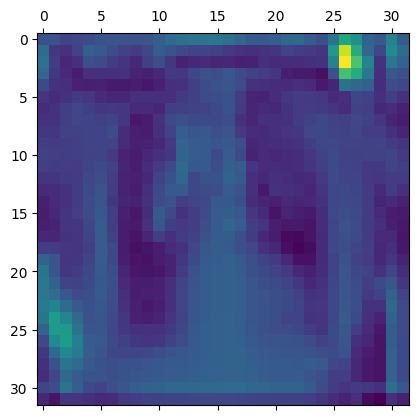

In [173]:
plt.matshow(heatmap)
plt.show()

In [174]:
# Map the heatmap onto the original sample space, accounting for the image size and value range.
# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = mpl.colormaps["jet"]

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
# Create an image with RGB colorized heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((test_image.shape[1], test_image.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

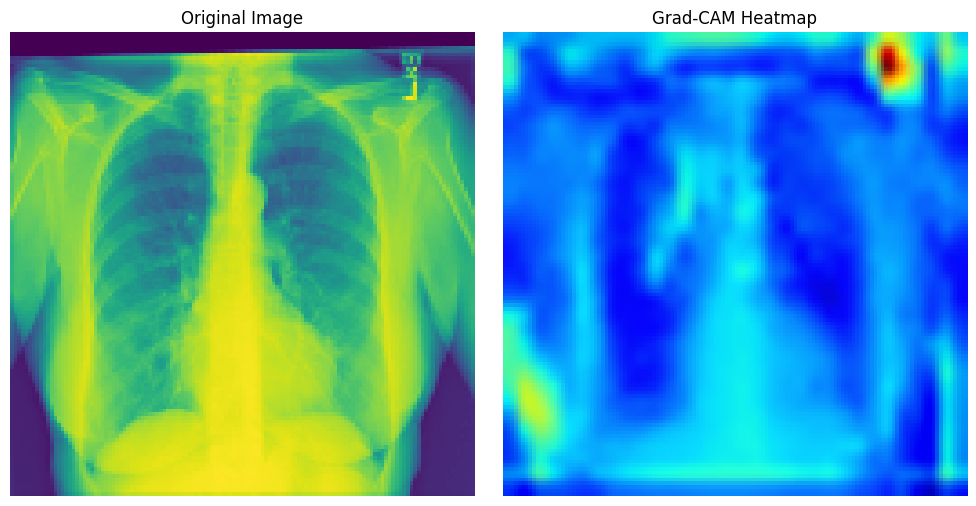

In [175]:
# Overlay the heatmap on the original image, by adding to its values rescaled by 0.4, and plot it.
alpha = 0.4

superimposed_test_image = jet_heatmap * alpha + test_image
superimposed_test_image = keras.utils.array_to_img(superimposed_test_image)

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis('off')

# Heatmap
plt.subplot(1, 2, 2)
plt.imshow(superimposed_test_image)
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Explaining the decision with Grad-CAM

In [ ]:
# Devide the test dataset into misclassified samples and break it further down by label, getting four distinct groups.


In [131]:
# Extract a few samples from each group and visualize their Grad-CAM explanations.